In [1]:
from google.colab import files
uploaded = files.upload()

Saving Dataset of Diabetes .csv to Dataset of Diabetes .csv


# 📦 IMPORT REQUIRED LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 📥 Load the dataset

In [3]:

data = pd.read_csv("Dataset of Diabetes .csv")
data['CLASS'] = data['CLASS'].str.strip()


# 🧹 Clean & preprocess

In [4]:

data = data[data['CLASS'].isin(['N', 'Y'])]  # Drop 'P' class if exists
data['Gender'] = data['Gender'].map({'F': 0, 'M': 1})
data = data.drop(['ID', 'No_Pation'], axis=1)  # Drop identifiers

# LABEL ENCODING CLASSES

In [5]:
y = LabelEncoder().fit_transform(data['CLASS'])  # 'N' -> 0, 'Y' -> 1
X = data.drop(['CLASS'], axis=1)

In [6]:
X.head()

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
0,0.0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
1,1.0,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0
2,0.0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
3,0.0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
4,1.0,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0


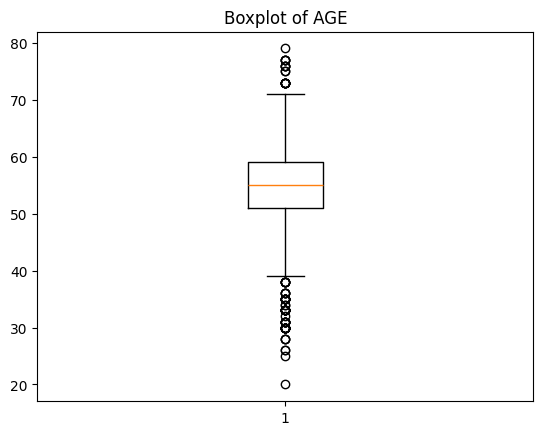

In [7]:
import matplotlib.pyplot as plt
plt.boxplot(X['AGE'])
plt.title('Boxplot of AGE')
plt.show()

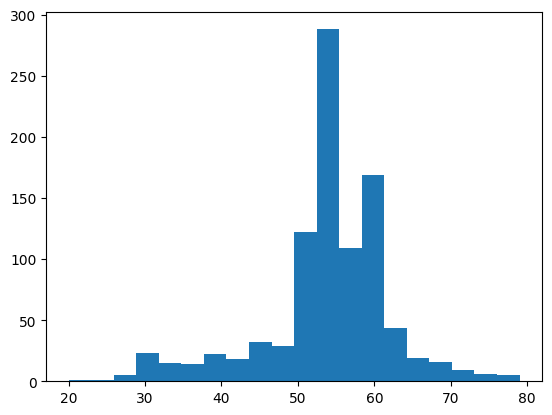

In [8]:
plt.hist(X['AGE'], bins=20)
plt.show()

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🧪 Check and clean invalid values

In [10]:
print("Any NaNs in scaled input?", np.isnan(X_scaled).any())
print("Any Infs in scaled input?", np.isinf(X_scaled).any())
X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

Any NaNs in scaled input? True
Any Infs in scaled input? False


# 🔁 Convert to tensors

In [11]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# 🧠 AE Architecture

In [12]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=4):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat  # ✅ Correct return


# ⚙️ Training AE

In [13]:
input_dim = X_tensor.shape[1]
ae = Autoencoder(input_dim)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [14]:
dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Trained for 300 epochs to get less loss (have runned this code 3 times)

In [34]:
for epoch in range(100):
    total_loss = 0
    for batch_x, _ in dataloader:
        optimizer.zero_grad()
        x_hat = ae(batch_x)
        loss = criterion(x_hat, batch_x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 1, Loss: 0.0660
Epoch 2, Loss: 0.0638
Epoch 3, Loss: 0.0620
Epoch 4, Loss: 0.0622
Epoch 5, Loss: 0.0605
Epoch 6, Loss: 0.0632
Epoch 7, Loss: 0.0647
Epoch 8, Loss: 0.0626
Epoch 9, Loss: 0.0612
Epoch 10, Loss: 0.0610
Epoch 11, Loss: 0.0617
Epoch 12, Loss: 0.0612
Epoch 13, Loss: 0.0628
Epoch 14, Loss: 0.0625
Epoch 15, Loss: 0.0643
Epoch 16, Loss: 0.0633
Epoch 17, Loss: 0.0617
Epoch 18, Loss: 0.0609
Epoch 19, Loss: 0.0617
Epoch 20, Loss: 0.0608
Epoch 21, Loss: 0.0615
Epoch 22, Loss: 0.0626
Epoch 23, Loss: 0.0619
Epoch 24, Loss: 0.0619
Epoch 25, Loss: 0.0615
Epoch 26, Loss: 0.0605
Epoch 27, Loss: 0.0594
Epoch 28, Loss: 0.0606
Epoch 29, Loss: 0.0606
Epoch 30, Loss: 0.0674
Epoch 31, Loss: 0.0675
Epoch 32, Loss: 0.0636
Epoch 33, Loss: 0.0623
Epoch 34, Loss: 0.0628
Epoch 35, Loss: 0.0620
Epoch 36, Loss: 0.0604
Epoch 37, Loss: 0.0601
Epoch 38, Loss: 0.0599
Epoch 39, Loss: 0.0593
Epoch 40, Loss: 0.0615
Epoch 41, Loss: 0.0607
Epoch 42, Loss: 0.0611
Epoch 43, Loss: 0.0618
Epoch 44, Loss: 0.06

# 🔍 Extract Latent Features

In [35]:
with torch.no_grad():
    latent_features = ae.encoder(X_tensor).numpy()

# Splitting Train and Test data

In [36]:
xTrain, xTest, yTrain, yTest = train_test_split(latent_features, y, test_size=0.2, random_state=42)

# 🧪 RFC Pipeline with GridSearchCV

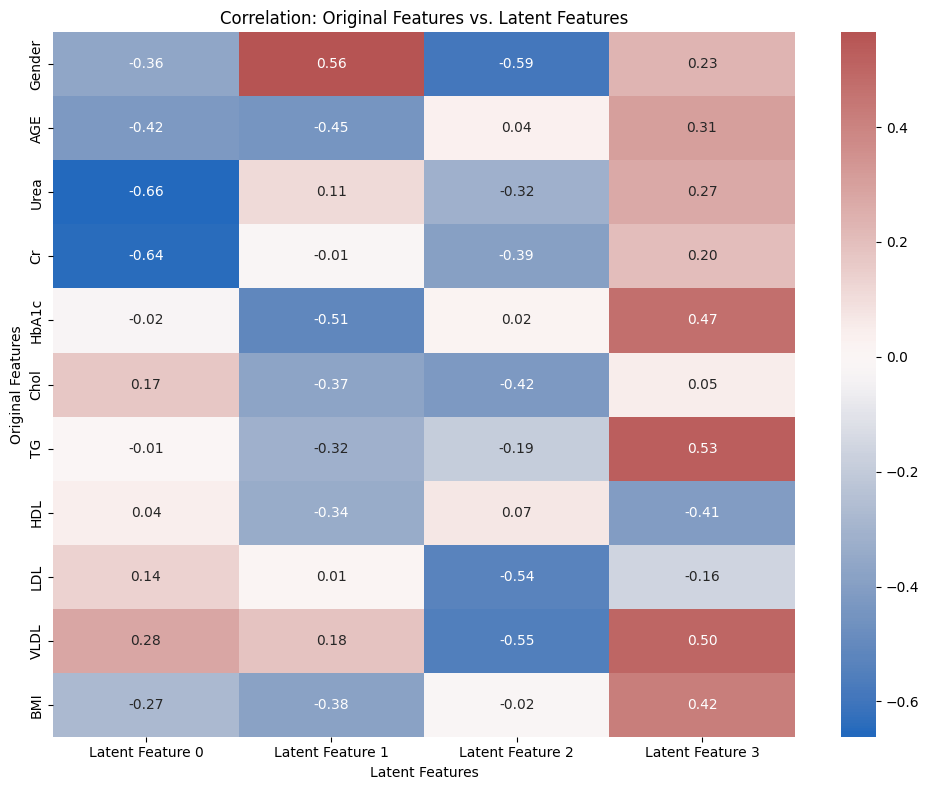

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Create a DataFrame for the original scaled features
# Make sure 'X_scaled' and 'X.columns' are from your preprocessing steps
df_scaled_original = pd.DataFrame(X_scaled, columns=X.columns)

# 2. Create a DataFrame for the new latent features
# 'latent_features' is the numpy array from your autoencoder
latent_dim = latent_features.shape[1]
latent_col_names = [f'Latent Feature {i}' for i in range(latent_dim)]
df_latent = pd.DataFrame(latent_features, columns=latent_col_names)

# 3. Concatenate them into one big DataFrame
df_combined = pd.concat([df_scaled_original, df_latent], axis=1)

# 4. Calculate the full correlation matrix
corr_matrix = df_combined.corr()

# 5. Isolate only the correlations we care about
# We want to see Original Features (rows) vs. Latent Features (columns)
correlation_of_interest = corr_matrix.loc[X.columns, latent_col_names]

# 6. Plot the heatmap
plt.figure(figsize=(10, 8)) # You can adjust the size
sns.heatmap(
    correlation_of_interest,
    annot=True,       # Show the correlation values
    fmt=".2f",        # Format to 2 decimal places
    cmap="vlag",      # A good diverging colormap (blue-white-red)
    center=0          # Center the colormap at 0, making it easy to see pos/neg
)
plt.title("Correlation: Original Features vs. Latent Features")
plt.ylabel("Original Features")
plt.xlabel("Latent Features")
plt.tight_layout()
plt.savefig("latent_feature_correlation.png") # Save the plot
plt.show()

In [38]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'clf__n_estimators': [100, 200, 300, 400, 500],
    'clf__max_depth': [None, 10, 20, 30, 40, 50],
    'clf__min_samples_split': [2,3,4, 5],
    'clf__class_weight': ['balanced']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_macro',  # better if classes are imbalanced
    n_jobs=-1,
    verbose=2
)

print("\n🔍 Running GridSearchCV on AE latent features...")



🔍 Running GridSearchCV on AE latent features...


In [40]:
# Fit on latent features
grid_search.fit(xTrain, yTrain)

# Best parameters
print("\n🏆 Best Parameters Found:")
print(grid_search.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits

🏆 Best Parameters Found:
{'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}


In [41]:
best_model = grid_search.best_estimator_
yPred = best_model.predict(xTest)

# ACCURACY and CLASSIFICATION REPORT with GridSearchCV

In [42]:
print("\n✅ Evaluation on AE latent features:")
print("Accuracy:", accuracy_score(yTest, yPred))
print("Classification Report:\n", classification_report(yTest, yPred))


✅ Evaluation on AE latent features:
Accuracy: 0.968421052631579
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.75      0.83        20
           1       0.97      0.99      0.98       170

    accuracy                           0.97       190
   macro avg       0.95      0.87      0.91       190
weighted avg       0.97      0.97      0.97       190



# ACCURACY and CLASSIFICATION REPORT only RFC Pipeline

In [43]:
y_pred_1 = pipeline.fit(xTrain, yTrain).predict(xTest)

print("\n✅ Evaluation on AE latent features:")
print("Accuracy:", accuracy_score(yTest, y_pred_1))
print("Classification Report:\n", classification_report(yTest, y_pred_1))


✅ Evaluation on AE latent features:
Accuracy: 0.9631578947368421
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.70      0.80        20
           1       0.97      0.99      0.98       170

    accuracy                           0.96       190
   macro avg       0.95      0.85      0.89       190
weighted avg       0.96      0.96      0.96       190



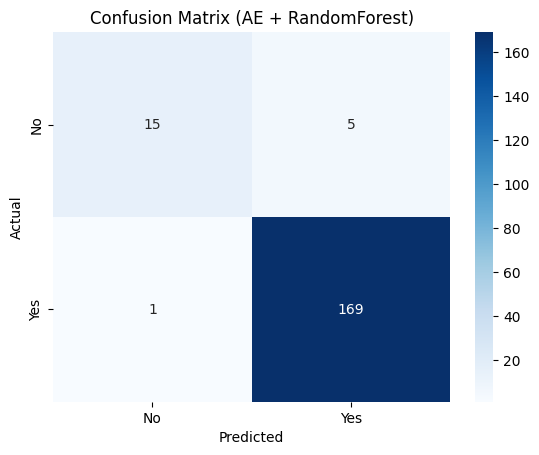

In [44]:
# 📉 Confusion Matrix
conf_matrix = confusion_matrix(yTest, yPred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (AE + RandomForest)')
plt.show()

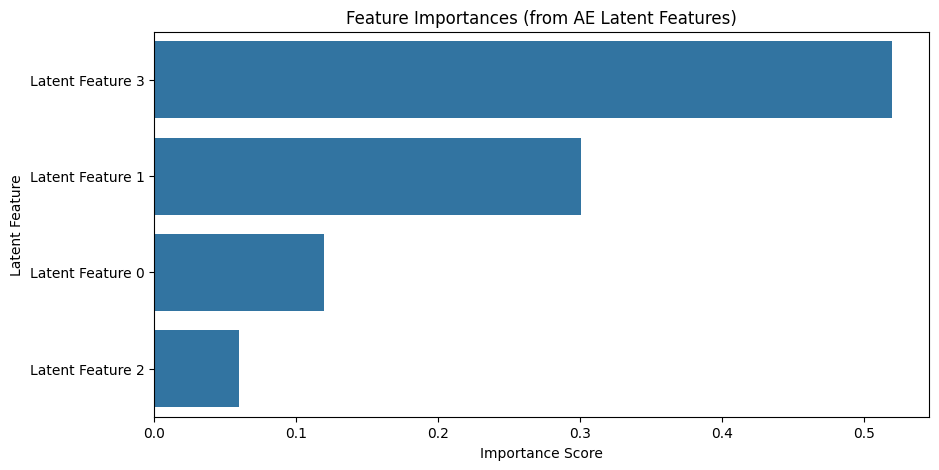

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the feature importances from the best model
# This model was trained on the latent features
importances_1 = best_model.named_steps['clf'].feature_importances_

# Get the number of latent features
num_latent_features = len(importances_1)

# Create the CORRECT labels for the latent features
# (e.g., 'Latent Feature 0', 'Latent Feature 1', ...)
latent_feature_names = [f'Latent Feature {i}' for i in range(num_latent_features)]

# Sort the importances and the new labels together
sorted_idx = np.argsort(importances_1)[::-1]
sorted_importances = importances_1[sorted_idx]
sorted_latent_names = np.array(latent_feature_names)[sorted_idx]

# Plotting the corrected feature importances
plt.figure(figsize=(10, 5))
sns.barplot(x=sorted_importances, y=sorted_latent_names)
plt.title("Feature Importances (from AE Latent Features)")
plt.xlabel("Importance Score")
plt.ylabel("Latent Feature")

# Save the plot as a file (optional, but good for notebooks)
plt.savefig("ae_feature_importances.png")
plt.show()

In [46]:
import joblib

In [47]:
model_name = 'AE_RFC.joblib'
joblib.dump(best_model, model_name)


['AE_RFC.joblib']

In [48]:
torch.save(ae.encoder.state_dict(), "encoder_model.pth")


In [49]:
model_name_s = 'Scaler.joblib'
joblib.dump(scaler,model_name_s)

['Scaler.joblib']

In [50]:
X.iloc[[1]]

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
1,1.0,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0


In [51]:
single_sample_original = X.iloc[[1]]
single_sample_scaled = scaler.transform(single_sample_original)
single_sample_latent = ae.encoder(torch.tensor(single_sample_scaled, dtype=torch.float32)).detach().numpy()
prediction = best_model.predict(single_sample_latent)
print(f"Prediction for the second sample: {prediction}")

Prediction for the second sample: [0]


In [52]:
best_model.predict_proba(single_sample_latent)

array([[0.96513273, 0.03486727]])

In [53]:
label_mapping = {0: 'N', 1: 'Y'}
predicted_class = label_mapping[prediction[0]]
print(f"The predicted class for the sample is: {predicted_class}")

The predicted class for the sample is: N
